# Data analysis on AOL user queries log

In this project, we will be studying the publicly released dataset of user search queries released by AOL for research purposes. We will seek to understand underlying patterns and statistics, and also seek to find out the interests of a user based on their searches.

## 1. Load and preprocess the data

The first step is to load the data. Our dataset consists of ten files named `user-ct-test-collection-01.txt` and so on, located in the folder `Dataset`. We will be using pandas to load them into Dataframes.
The dataset contains five columns - _AnonID_, _Query_, _QueryTime_, _ItemRank_ and _ClickURL_. _AnonID_ is the anonymised ID of the user which performed the _Query_. _QueryTime_ is simply the timestamp of when it was executed. _ItemRank_ is the rank of the URL which was clicked upon, _ClickURL_, among the search results provided by the AOL search engine. 

For the purposes of our project, _ClickURL_ poses no significant information, so we will be dropping this field. Also, it was noted that there existed plenty of blank ('-') queries in the dataset. The corresponding rows have been removed as well.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from processInput import readFile, readDataset

In [2]:
ds = readFile('../Dataset/user-ct-test-collection-01.txt')
ds = ds[ds['Query']!='-']
ds.head()

,AnonID,Query,QueryTime,ItemRank
0,142,rentdirect.com,2006-03-01 07:17:12,NaN
1,142,www.prescriptionfortime.com,2006-03-12 12:31:06,NaN
2,142,staple.com,2006-03-17 21:19:29,NaN
3,142,staple.com,2006-03-17 21:19:45,NaN
4,142,www.newyorklawyersite.com,2006-03-18 08:02:58,NaN


In [3]:
print ds.dtypes

AnonID                int64
Query                object
QueryTime    datetime64[ns]
ItemRank            float64
dtype: object


## 2. Analyse the data

After having loaded the data, we move forward to unearthing interesting patterns and information present in the data.

### Peak Traffic Hours

It would be useful to know when the website faced the most traffic, i.e. when an arbitrary user was most likely to generate a search request. 

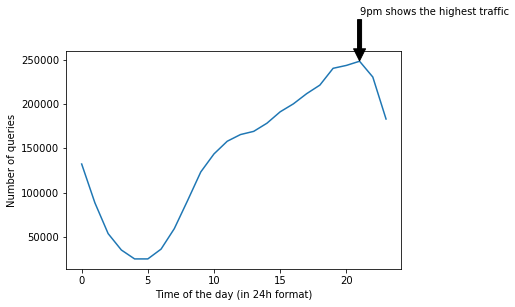

In [4]:
hourData = ds['QueryTime'].dt.hour
hist = hourData.value_counts()
hist = hist.sort_index()
hist.plot()
plt.ylabel('Number of queries')
plt.xlabel('Time of the day (in 24h format)')
plt.annotate('9pm shows the highest traffic', xy=(21, hist[21]), xytext=(21, 300000), arrowprops=dict(facecolor='black', shrink=0.01))
plt.show()

From the above chart, it is clear that 9pm - 10pm shows the peak usage whereas 4am - 5am shows the least.

### Average ItemRank

To judge the efficacy of AOL as a search engine, the quality of results displayed first is studied. We posit that if a user clicked on a link, then it possessed good quality, or was relevant. Then, the lower the _ItemRank_, the better AOL served its user. By calculating the average ItemRank, we can make an assessment on AOL's performance.

In [5]:
rank = ds['ItemRank']
rank.describe()

count    1.860538e+06
mean     6.779084e+00
std      1.956991e+01
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      5.000000e+02
Name: ItemRank, dtype: float64

The mean is rather high at __6.8__, with a standard deviation of __19.6__. If we look at the maximum value, we see that values of 500 are being reached. These are outliers. We perform binning for a more thorough understanding.

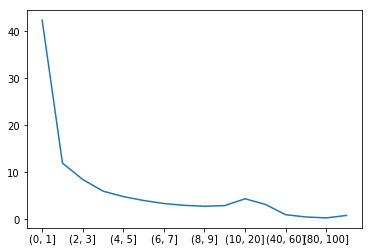

In [6]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60, 80, 100, 500]
binnedRank = pd.cut(rank, bins)
countRank = binnedRank.count()
binnedRank = binnedRank.value_counts().sort_index()
percentageRank = binnedRank / float(countRank) * 100
percentageRank.plot()
plt.show()

In [7]:
cumulativePercentageRank = binnedRank.cumsum()
cumulativePercentageRank = cumulativePercentageRank / float(countRank) * 100
cumulativePercentageRank = [ round(x, 2) for x in cumulativePercentageRank ]

print "Percentage of people who found what they were looking for "
print "- in first result \t= " + str( cumulativePercentageRank[0] )
print "- in top five results \t= " + str( cumulativePercentageRank[4] )
print "- in first page \t= " + str( cumulativePercentageRank[9] )
print "- in first 2 pages \t= " + str( cumulativePercentageRank[10] )

Percentage of people who found what they were looking for 
- in first result 	= 42.39
- in top five results 	= 73.69
- in first page 	= 89.8
- in first 2 pages 	= 94.18


### Percentage of queries that were simply URLs

One curious phenomenon observed in the dataset is that many users typed the URL name in the AOL search bar, rather than the respective browser's address bar. We seek to find just how many of the queries were such misplaced entries.

In [8]:
queries = ds['Query']
queries = queries.str.lower()
countQueries = queries.count()

typicalWebsiteName = r'(([a-z]{3})\.)?([a-z]+)\.([a-z]{2,3})'
containsURL = queries.str.match(typicalWebsiteName)
countURLQueries = containsURL[ containsURL == True ].count()

percentageURLQueries = float(countURLQueries) / countQueries * 100
print round(percentageURLQueries, 2)

18.08


As we can see above, __18.08%__ of the queries submitted were simply to navigate to a particular webpage!

### Average number of queries submitted by Users

By knowing how many queries an average user submits, we can know the general reliance placed by the average user for searching items via AOL. 

In [9]:
countQueriesPerUser = ds.groupby('AnonID').size()
countQueriesPerUser.describe()

count    64942.000000
mean        53.269379
std        121.301427
min          1.000000
25%          5.000000
50%         17.000000
75%         51.000000
max       3752.000000
dtype: float64

Thus, the average number of queries submitted over a period of 90 days is __53__, or approximately __3 queries every 5 days__.

### Most Popular Queries

The queries that were most often searched for are listed below.

In [10]:
popularQueries = ds['Query'].value_counts()
print popularQueries[0:20]

google             32163
yahoo              13646
ebay               13075
yahoo.com           8743
mapquest            8719
myspace.com         8587
google.com          7985
myspace             6877
www.yahoo.com       4240
internet            4207
www.google.com      3981
www.myspace.com     3034
my space            3008
ebay.com            2978
map quest           2899
http                2840
weather             2676
pogo                2307
american idol       2279
craigslist          2232
Name: Query, dtype: int64


## 3. Find user's interests

The methodology that is adopted is equally applicable to any user, and does not change from user to user. Thus, for demonstration purposes, it is sufficient to showcase the method applied on a specific user.

Ideally, such a user must have a large number of distinct queries so that we can extract a lot of information.

In [11]:
userAndQueries = ds[['AnonID', 'Query']]
userAndQueries = userAndQueries.drop_duplicates(subset='Query')
usersOfInterest = userAndQueries.groupby('AnonID').size()
usersOfInterest.loc[ lambda s: s>150 ].head()

AnonID
2722     248
4781     212
6497     480
8041     180
13508    303
dtype: int64

We arbitrarily choose user ID __2722__. The number of queries generated are __248__. Some of the queries are listed below.

In [12]:
# userAndQueries[ userAndQueries['AnonID'] == 13993001 ]
user = userAndQueries[ userAndQueries['AnonID'] == 2722 ]
querySet = user['Query']
querySet

570                                          charles drew
574                                   national car rental
575                                              military
576                               military rental benfits
577                              military rental benefits
578                          military car rental benefits
581                                        deers id cards
582                                   deers id cards army
583                                               tricare
584                                  www.publixdirect.com
586                                                publix
590                                         waldrop hills
595                                         sprint phones
596                                                 fafsa
597                                         georgia state
598                                         clayton state
599                                     georgia perimeter
600           

Now, our end goal is to obtain the interest of the user. More specifically, we seek to calculate certain _tags_, or words of importance, which bear a high correlation with the interests of our user. 

To calculate these tags however, we need a much larger set of terms than just the query words. To overcome this, we scrape the search results of `www.duckduckgo.com` and populate a dataset. DuckDuckGo was specifically chosen because
- it allows for scraping, unlike Google
- it does not consider demographic or any personal information while displaying results

The latter is especially important so as to obtain unbiased results.


In [16]:
import search
reload(search)

queryList = querySet.tolist()
search.searchAndStore(queryList, resultsPerQuery=4, savepath='../User2722/', saveURL=True)

 Extracting result urls...

ConnectionError: HTTPSConnectionPool(host='www.duckduckgo.com', port=443): Max retries exceeded with url: /html/?q=charles+drew (Caused by <class 'socket.error'>: [Errno 104] Connection reset by peer)

In [33]:
import tf_idf
reload(tf_idf)
tf_idf.calc_and_store_tf_idf('../User2722Incomplete/')

Indexing docuement collection...
Indexed.
Computing tf_idf...
Computed.


In [34]:
import post_tf_idf
reload(post_tf_idf)
post_tf_idf.cluster('../User2722Incomplete/',8)


Cluster 1
clayton
shirts
sweatshirts
women
men
camp
meadowcreek
hats
force
synovus


Cluster 2
shift
byeacrzw
napa
knob
shipping
auto
parts
buy
brand
condo


Cluster 3
storage
patina
publix
retrieved
football
ingles
meadowcreek
school
kudzu
rental


Cluster 4
hyundai
elantra
tax
vehicle
routing
dealer
parts
apr
lease
bank


Cluster 5
cake
butterfly
hut
pizza
birthday
recipes
party
cakes
chocolate
tulle


Cluster 6
tune
mybook
clinic
auto
yelp
collection
georgia
ellenwood
repair
appointment


Cluster 7
tweet
password
duration
close
autozone
retweeted
embed
retweet
verified
views


Cluster 8
college
student
students
campus
admissions
aid
benefits
military
university
gpc

